# Effective and efficient diffusion

- Ref: https://huggingface.co/docs/diffusers/v0.34.0/en/stable_diffusion

In [1]:
import torch
import time

if torch.backends.mps.is_available():
    t_device = torch.device("mps")
    s_device = "mps"
    print(f"Current memory allocated on MPS: {torch.mps.current_allocated_memory()} bytes")
    print(f"Driver memory allocated on MPS: {torch.mps.driver_allocated_memory()} bytes")
elif torch.cuda.is_available():
    t_device = torch.device("cuda")
    s_device = "cuda"
    !nvidia-smi
else:
    t_device = torch.device("cpu")
    s_device = "cpu"
print(t_device)


Wed Oct  1 07:11:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.57.08              Driver Version: 575.57.08      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     On  |   00000000:01:00.0  On |                  N/A |
| 50%   50C    P5             41W /  250W |    1133MiB /  11264MiB |     42%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Elapsed time: 4.0085 seconds
the original size (512, 512)


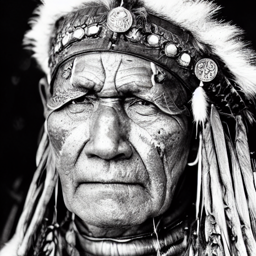

In [3]:
from diffusers import DiffusionPipeline

model_id = "stable-diffusion-v1-5/stable-diffusion-v1-5"
if s_device == "cuda":
    pipeline = DiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16, use_safetensors=True)
else:
    pipeline = DiffusionPipeline.from_pretrained(model_id)
pipeline = pipeline.to(t_device)

generator = torch.Generator(t_device).manual_seed(0)
prompt = "portrait photo of a old warrior chief"

s_time = time.time()
pnd_output = pipeline(prompt, generator=generator)
print(f"Elapsed time: {time.time() - s_time:.4f} seconds")
print(f"the original size {pnd_output.images[0].size}")
pnd_image = pnd_output.images[0].resize((256, 256))
pnd_image

  0%|          | 0/20 [00:00<?, ?it/s]

Elapsed time: 1.7411 seconds
the original size (512, 512)


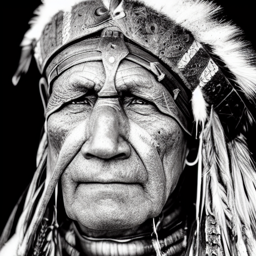

In [4]:
from diffusers import DPMSolverMultistepScheduler
pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config)

s_time = time.time()
generator = torch.Generator(t_device).manual_seed(0)
dpm_output = pipeline(prompt, generator=generator, num_inference_steps=20)
print(f"Elapsed time: {time.time() - s_time:.4f} seconds")

dpm_image = dpm_output.images[0]
print(f"the original size {dpm_image.size}")
dpm_image.resize((256, 256))

  0%|          | 0/20 [00:00<?, ?it/s]

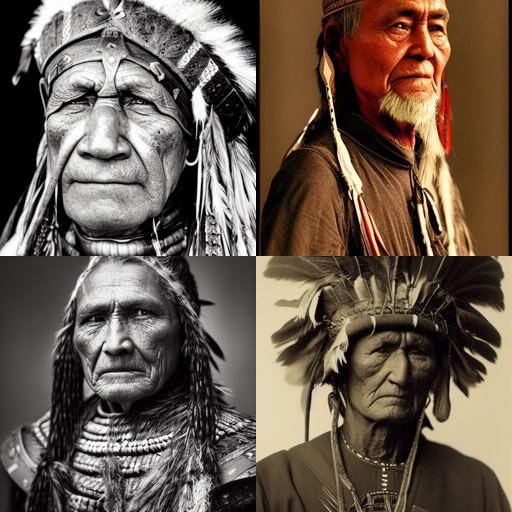

In [5]:
def get_inputs(batch_size=1):
    generator = [torch.Generator(t_device).manual_seed(i) for i in range(batch_size)]
    prompts = batch_size * [prompt]
    num_inference_steps = 20

    return {"prompt": prompts, "generator": generator, "num_inference_steps": num_inference_steps}

from diffusers.utils import make_image_grid

batch_output = pipeline(**get_inputs(batch_size=4))
batch_images = batch_output.images
batch_images = list(map(lambda x: x.resize((256, 256)), batch_images))
make_image_grid(batch_images, 2, 2)

## Qulaity

  0%|          | 0/20 [00:00<?, ?it/s]

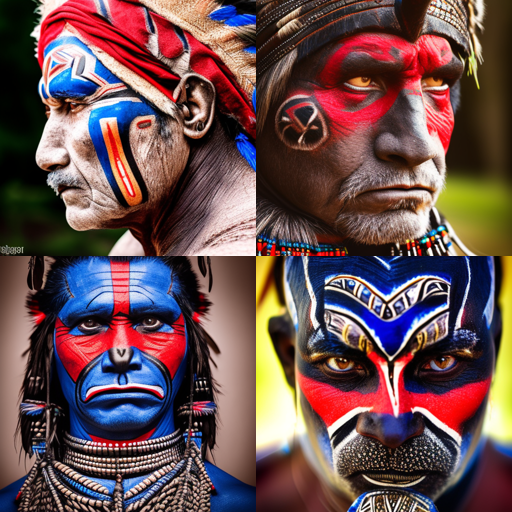

In [12]:
from diffusers import AutoencoderKL

if s_device == "cuda":
    vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", torch_dtype=torch.float16).to(t_device)
else:
    vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse").to(t_device)
pipeline.vae = vae
images = pipeline(**get_inputs(batch_size=4)).images
images = list(map(lambda x: x.resize((256, 256)), images))
make_image_grid(images, rows=2, cols=2)

Token indices sequence length is longer than the specified maximum sequence length for this model (89 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['-- beta -- ar 2 : 3 -- beta -- upbeta', '-- beta -- ar 2 : 3 -- beta -- upbeta', '-- beta -- ar 2 : 3 -- beta -- upbeta', '-- beta -- ar 2 : 3 -- beta -- upbeta']


  0%|          | 0/20 [00:00<?, ?it/s]

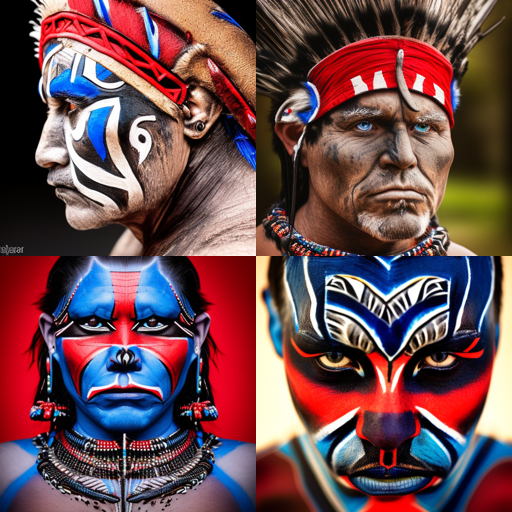

In [13]:
prompt += ", tribal panther make up, blue on red, side profile, looking away, serious eyes"
prompt += " 50mm portrait photography, hard rim lighting photography--beta --ar 2:3  --beta --upbeta"
images = pipeline(**get_inputs(batch_size=4)).images
images = list(map(lambda x: x.resize((256, 256)), images))
make_image_grid(images, rows=2, cols=2)


  0%|          | 0/25 [00:00<?, ?it/s]

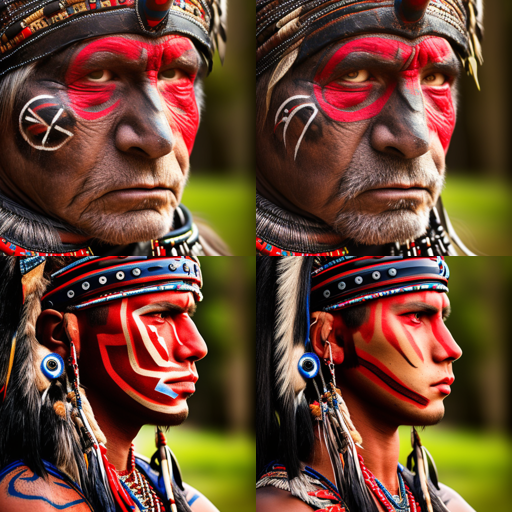

In [14]:
prompts = [
    "portrait photo of the oldest warrior chief, tribal panther make up, blue on red, side profile, looking away, serious eyes 50mm portrait photography, hard rim lighting photography--beta --ar 2:3  --beta --upbeta",
    "portrait photo of an old warrior chief, tribal panther make up, blue on red, side profile, looking away, serious eyes 50mm portrait photography, hard rim lighting photography--beta --ar 2:3  --beta --upbeta",
    "portrait photo of a warrior chief, tribal panther make up, blue on red, side profile, looking away, serious eyes 50mm portrait photography, hard rim lighting photography--beta --ar 2:3  --beta --upbeta",
    "portrait photo of a young warrior chief, tribal panther make up, blue on red, side profile, looking away, serious eyes 50mm portrait photography, hard rim lighting photography--beta --ar 2:3  --beta --upbeta",
]

generator = [torch.Generator(t_device).manual_seed(1) for _ in range(len(prompts))]
images = pipeline(prompt=prompts, generator=generator, num_inference_steps=25).images
images = list(map(lambda x: x.resize((256, 256)), images))
make_image_grid(images, 2, 2)